In [1]:
import json
import os

import tqdm
import datetime
import pytz

import pandas

%matplotlib widget
import matplotlib
import matplotlib.pyplot

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
root_path = '/Users/matthieu/.ssh/ssh_to_graz/metadata/' + source_computer + '/'
data_path = root_path + 'pickle_files/'
conf_path = root_path + 'config/'

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
print(pfiles)

['metadata_waggles20230714.pickle', 'metadata_waggles20230715.pickle', 'metadata_waggles20230716.pickle', 'metadata_waggles20230717.pickle', 'metadata_waggles20230718.pickle', 'metadata_waggles20230719.pickle', 'metadata_waggles20230720.pickle', 'metadata_waggles20230721.pickle', 'metadata_waggles20230722.pickle', 'metadata_waggles20230723.pickle', 'metadata_waggles20230724.pickle', 'metadata_waggles20230725.pickle', 'metadata_waggles20230726.pickle', 'metadata_waggles20230727.pickle', 'metadata_waggles20230728.pickle', 'metadata_waggles20230729.pickle', 'metadata_waggles20230730.pickle', 'metadata_waggles20230731.pickle']


# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]
all_waggles_df.head(5)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
0,18434927546356664479,205,-1.143186,4.589325,0.788175,2,2023-07-14 16:45:07.475806+00:00,2023-07-14 16:45:08.125847+00:00,1550.0,944.0,...,1550.0,960.0,2023-07-14,0.650041,-3.348960,-6.062942,-0.330431,-347.381006,-18.932303,True
1,17207792881295891939,205,-2.244534,4.589325,0.862588,2,2023-07-14 16:45:02.158845+00:00,2023-07-14 16:45:02.775513+00:00,1586.0,960.0,...,1606.0,976.0,2023-07-14,0.616668,-3.348695,-7.164026,-0.330166,-410.468442,-18.917145,True
2,10734887546593850369,206,2.796986,2.929605,0.573601,2,2023-07-14 16:45:23.210104+00:00,2023-07-14 16:45:23.676807+00:00,1454.0,992.0,...,1446.0,1000.0,2023-07-14,0.466703,-3.349742,-2.123553,-1.990934,-121.670631,-114.072113,True
3,10228066394540439103,206,-3.097191,2.924824,0.752396,2,2023-07-14 16:45:27.126987+00:00,2023-07-14 16:45:27.293644+00:00,1446.0,1136.0,...,1446.0,1136.0,2023-07-14,0.166657,-3.349937,-8.017924,-1.995910,-459.393219,-114.357214,True
4,10436701760110499376,205,-1.186604,4.775544,0.751323,2,2023-07-14 16:45:09.292561+00:00,2023-07-14 16:45:09.575921+00:00,1526.0,944.0,...,1510.0,960.0,2023-07-14,0.283360,-3.349050,-6.106450,-0.144302,-349.873829,-8.267896,True


# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

# exp_configs

In [5]:
# load output bridge data
wdd_log_file = conf_path+'wdd_bridge_output.txt'
bridge_lines = []
corrupted_lines = 0
with open(wdd_log_file, "r") as f:
    for line in f:
        try :
            data = json.loads(line)
        except :
            corrupted_lines += 1
        data["UTC_timestamp"] = pytz.UTC.localize(datetime.datetime.fromisoformat(data["log_timestamp"]))
        bridge_lines.append(data)
print("Output contained {} corrupted lines".format(corrupted_lines))
bridge_output = pandas.DataFrame.from_dict(bridge_lines)

Output contained 0 corrupted lines


# Dances clustering and visu (Day by day)

In [6]:
day_oi = pytz.utc.localize(datetime.datetime(2023, 7, 21))

daily_waggles = all_waggles_df[all_waggles_df.timestamp_begin > day_oi]
daily_waggles = daily_waggles[daily_waggles.timestamp_begin < day_oi+datetime.timedelta(1)]

daily_waggles

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
90482,9716815815602901922,0,0.967858,1.222612,0.547454,2,2023-07-21 01:10:11.494224+00:00,2023-07-21 01:10:11.794489+00:00,550.000000,1312.000000,...,542.000000,1316.000000,2023-07-21,0.300265,1.036450,0.433512,0.688265,24.838417,39.434704,True
90483,9876571213479157409,0,1.477365,1.222612,0.480218,2,2023-07-21 01:10:09.860713+00:00,2023-07-21 01:10:11.227558+00:00,550.000000,1304.000000,...,542.000000,1288.000000,2023-07-21,1.366845,1.036558,0.943127,0.688373,54.037173,39.440886,True
90490,15919629898216803203,2355,-1.348078,5.003479,0.540148,2,2023-07-21 16:45:29.229806+00:00,2023-07-21 16:45:30.079860+00:00,1534.000000,1016.000000,...,1518.000000,1024.000000,2023-07-21,0.850054,-3.332356,-6.251231,0.100327,-358.169126,5.748308,True
90491,18015567632386744516,2356,-0.999065,5.485691,0.672371,2,2023-07-21 16:45:40.380304+00:00,2023-07-21 16:45:40.797010+00:00,1486.000000,952.000000,...,1486.000000,976.000000,2023-07-21,0.416706,-3.332916,-5.902777,0.581979,-338.204216,33.344940,True
90492,12775946359622833791,2356,-0.076611,4.943874,0.792287,2,2023-07-21 16:45:58.881340+00:00,2023-07-21 16:45:59.797973+00:00,1408.654378,1058.654378,...,1509.963134,1098.654378,2023-07-21,0.916633,-3.333844,-4.981251,0.039234,-285.404677,2.247922,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112542,11358543081099760082,2608,-2.308002,3.823359,0.527932,2,2023-07-21 18:18:57.183282+00:00,2023-07-21 18:18:57.749979+00:00,1590.000000,944.000000,...,1574.000000,950.273128,2023-07-21,0.566697,-3.615957,-7.494756,-1.363394,-429.417869,-78.116735,True
112543,12598973864309785366,2608,3.073511,3.674296,0.667592,2,2023-07-21 18:18:47.132677+00:00,2023-07-21 18:18:47.749573+00:00,1608.654378,962.654378,...,1603.308756,925.308756,2023-07-21,0.616896,-3.615434,-2.112719,-1.511935,-121.049881,-86.627469,True
112544,10586736725446549627,2608,-2.832002,3.819018,0.756012,2,2023-07-21 18:18:50.549667+00:00,2023-07-21 18:18:52.082969+00:00,1606.000000,940.000000,...,1606.000000,984.000000,2023-07-21,1.533302,-3.615612,-8.018410,-1.367390,-459.421044,-78.345659,True
112545,10820112588326474327,2607,-2.042682,4.176593,0.697393,2,2023-07-21 18:18:11.247601+00:00,2023-07-21 18:18:11.680959+00:00,1446.000000,1056.000000,...,1434.000000,1060.000000,2023-07-21,0.433358,-3.613567,-7.227046,-1.007771,-414.079209,-57.741003,True


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class DBSCAN:
    def __init__(self, min_samples, tol_time, tol_x, tol_y, tol_angle):
        self.min_samples = min_samples
        self.tol_time = tol_time
        self.tol_x = tol_x
        self.tol_y = tol_y
        self.tol_angle = tol_angle

    def connection_function(self, pt0, pt1):
        if abs((pt1.timestamp_begin - pt0.timestamp_begin).total_seconds()) > self.tol_time:
            return 0
        if abs(pt1.wdd_x - pt0.wdd_x) > self.tol_x:
            return 0
        if abs(pt1.wdd_y - pt0.wdd_y) > self.tol_y:
            return 0
        if abs(pt1.dance_world_angle_deg - pt0.dance_world_angle_deg)%360 > self.tol_angle:
            return 0
        return 1
    
    def fit(self, X):
        self.X = X
        self.labels = [0] * len(self.X)
        self.visited = [False] * len(self.X)
        self.cluster_id = 0

        for i in range(len(self.X)):
            if not self.visited[i]:
                self.visited[i] = True
                neighbors = self.region_query(i)

                if len(neighbors) < self.min_samples:
                    self.labels[i] = -1
                else:
                    self.cluster_id += 1
                    self.expand_cluster(i, neighbors)

    def region_query(self, i):
        neighbors = []
        for j in range(len(self.X)):
            if self.connection_function(self.X.iloc[i], self.X.iloc[j]):
                neighbors.append(j)
        return neighbors

    def expand_cluster(self, i, neighbors):
        self.labels[i] = self.cluster_id
        j = 0
        while j < len(neighbors):
            neighbor_idx = neighbors[j]

            if not self.visited[neighbor_idx]:
                self.visited[neighbor_idx] = True
                new_neighbors = self.region_query(neighbor_idx)

                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors

            if self.labels[neighbor_idx] == 0:
                self.labels[neighbor_idx] = self.cluster_id

            j += 1


In [8]:
label_conf   = 0.99  # percent
clustering_df = daily_waggles[daily_waggles.label_confidence>label_conf]
clustering_df = clustering_df[clustering_df.timestamp_begin>day_oi+datetime.timedelta(hours=12.25)]
clustering_df = clustering_df[clustering_df.timestamp_begin<day_oi+datetime.timedelta(hours=14.25)]

print(len(clustering_df))

378


In [9]:
angle_tol    = 30    # degrees
time_tol     = 5     # seconds
posx_tol     = 100   # pixels (100px ~ 25mm) trop restrictif?
posy_tol     = 100   # pixels
min_pts      = 3     # nb wr min to make a dance

# Apply DBSCAN (takes around 1min 40s for 600 datapoints (does not scale linearly : 2200pts --> more than 25 mins))
dbscan = DBSCAN(min_samples=min_pts, tol_time=time_tol, tol_x=posx_tol, tol_y=posy_tol, tol_angle=angle_tol)
dbscan.fit(clustering_df)
clustering_df['cluster'] = dbscan.labels
no_noise_df = clustering_df[clustering_df.cluster >= 0]

In [10]:
print("Total number of clusters (WD) : {}".format(clustering_df.cluster.unique().shape[0]-1))
# print("Size of the clusters (WR per WD) : min={}, max={}, average={}, median={}".format(clustering_df[clustering_df.cluster > 0].cluster.value_counts().min(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().max(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().mean(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().median()))

Total number of clusters (WD) : 32


In [11]:
print(clustering_df[clustering_df.cluster > 0].cluster.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]


In [12]:
print(clustering_df[clustering_df.cluster > 0].cluster.value_counts())

22    10
30    10
4      7
11     6
1      5
18     5
23     5
21     5
3      5
20     4
12     4
7      4
2      4
27     3
29     3
25     3
24     3
31     3
26     3
17     3
15     3
14     3
13     3
10     3
32     3
19     2
16     2
9      2
28     2
8      2
5      2
6      1
Name: cluster, dtype: int64


In [13]:
print(clustering_df[clustering_df.cluster > 0].cluster.value_counts())

22    10
30    10
4      7
11     6
1      5
18     5
23     5
21     5
3      5
20     4
12     4
7      4
2      4
27     3
29     3
25     3
24     3
31     3
26     3
17     3
15     3
14     3
13     3
10     3
32     3
19     2
16     2
9      2
28     2
8      2
5      2
6      1
Name: cluster, dtype: int64


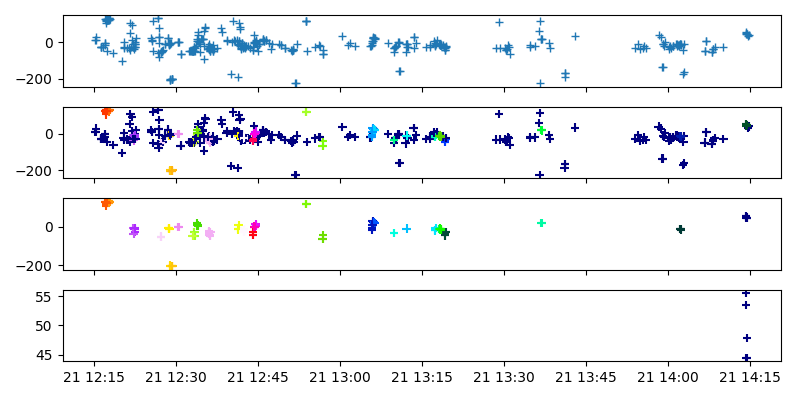

In [14]:
# Plot
fig, ax = matplotlib.pyplot.subplots(4, 1, figsize=(8, 4), sharex=True)
ax[0].plot(clustering_df.timestamp_begin, clustering_df.dance_world_angle_deg, '+')
ax[1].scatter(clustering_df.timestamp_begin, clustering_df.dance_world_angle_deg, c=clustering_df['cluster'], cmap='gist_ncar', marker='+')
ax[2].scatter(no_noise_df.timestamp_begin, no_noise_df.dance_world_angle_deg, c=no_noise_df['cluster'], cmap='gist_ncar', marker='+')
cluster_oi = clustering_df[clustering_df.cluster == 1]
ax[3].scatter(cluster_oi.timestamp_begin, cluster_oi.dance_world_angle_deg, c=cluster_oi['cluster'], cmap='gist_ncar', marker='+')
fig.tight_layout()

In [15]:
[print(x) for x in sorted(list(cluster_oi.timestamp_begin.values))]

2023-07-21T14:14:19.248696000
2023-07-21T14:14:22.332254000
2023-07-21T14:14:24.118714000
2023-07-21T14:14:27.749160000
2023-07-21T14:14:29.417866000


[None, None, None, None, None]

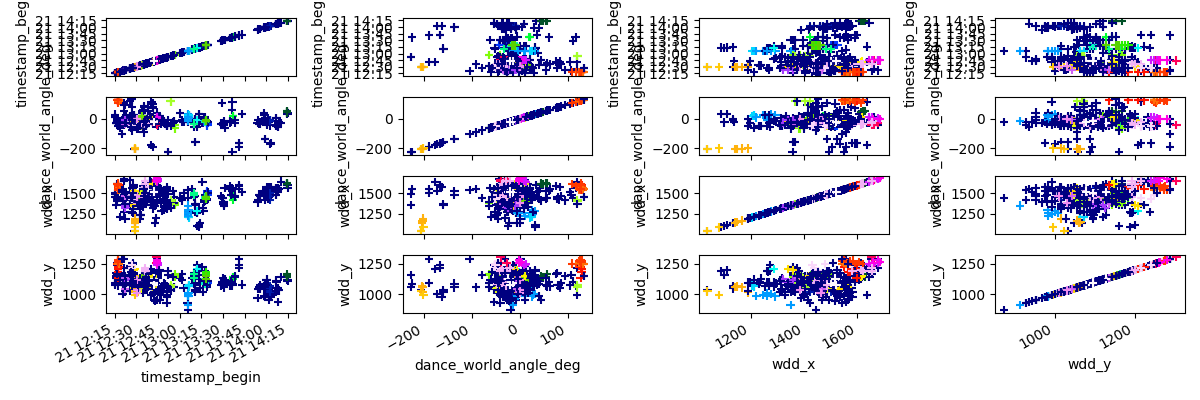

In [16]:
# Plot
features = ['timestamp_begin', 'dance_world_angle_deg', 'wdd_x', 'wdd_y']
fig, ax = matplotlib.pyplot.subplots(len(features), len(features), figsize=(12, 4))
for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        ax[i,j].scatter(clustering_df[feat2], clustering_df[feat1], c=clustering_df['cluster'], cmap='gist_ncar', marker='+')
        ax[i,j].set_ylabel(feat1)
        ax[i,j].set_xlabel(feat2)

# for i, feat1 in enumerate(features):
#     ax[i,0].set_ylabel(feat1)
#     ax[len(features)-1,i].set_xlabel(feat1)
matplotlib.pyplot.gcf().autofmt_xdate()
fig.tight_layout()

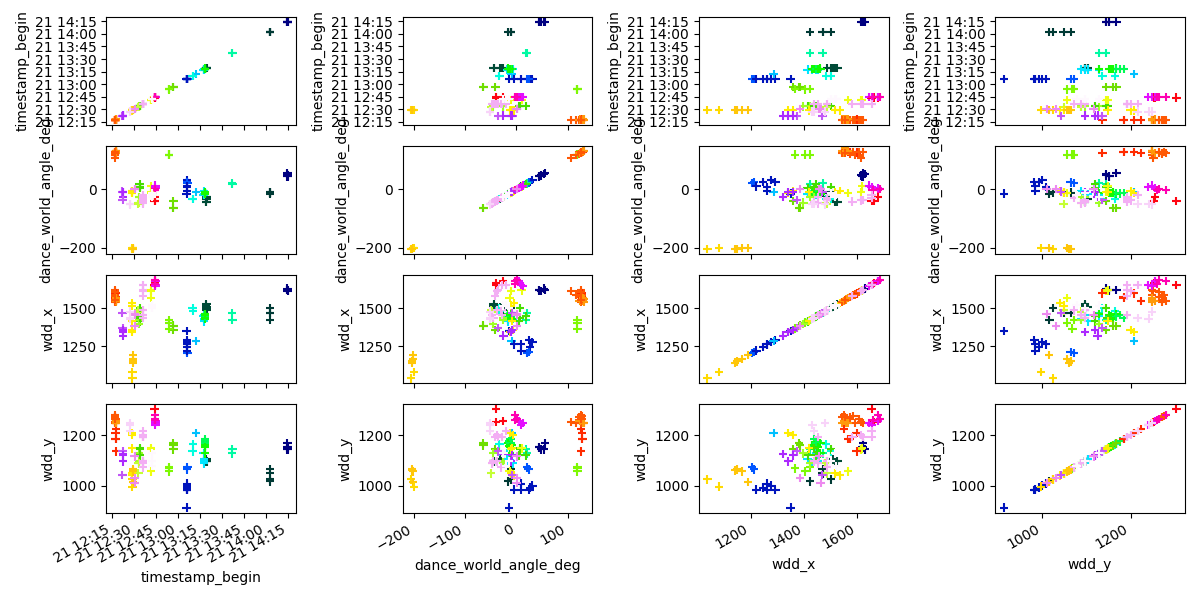

In [17]:
# Plot
features = ['timestamp_begin', 'dance_world_angle_deg', 'wdd_x', 'wdd_y']
fig, ax = matplotlib.pyplot.subplots(len(features), len(features), figsize=(12, 6))
for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        ax[i,j].scatter(no_noise_df[feat2], no_noise_df[feat1], c=no_noise_df['cluster'], cmap='gist_ncar', marker='+')
        ax[i,j].set_ylabel(feat1)
        ax[i,j].set_xlabel(feat2)

# for i, feat1 in enumerate(features):
#     ax[i,0].set_ylabel(feat1)
#     ax[len(features)-1,i].set_xlabel(feat1)
matplotlib.pyplot.gcf().autofmt_xdate()
fig.tight_layout()

In [18]:
no_noise_df.head(16)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance,cluster
92299,17172403516113054151,2090,-2.769075,5.170787,0.779660,2,2023-07-21 14:14:27.749160+00:00,2023-07-21 14:14:28.215921+00:00,1618.0,1152.0,...,1160.000000,2023-07-21,0.466761,-2.825065,-7.164936,0.774926,-410.520575,44.400015,True,1
92305,14635770348020180501,2090,-0.810297,5.365136,0.836055,2,2023-07-21 14:14:22.332254+00:00,2023-07-21 14:14:22.982333+00:00,1622.0,1168.0,...,1184.000000,2023-07-21,0.650079,-2.824697,-5.205791,0.969642,-298.269839,55.556392,True,1
92307,16800622269451459704,2090,-1.024173,5.329025,0.747663,2,2023-07-21 14:14:19.248696+00:00,2023-07-21 14:14:19.565367+00:00,1630.0,1144.0,...,1112.000000,2023-07-21,0.316671,-2.824488,-5.419458,0.933740,-310.512058,53.499383,True,1
92308,16281211416483684400,2090,-1.986431,5.170787,0.361533,2,2023-07-21 14:14:24.118714+00:00,2023-07-21 14:14:24.482327+00:00,1622.0,1152.0,...,1160.000000,2023-07-21,0.363613,-2.824819,-6.382046,0.775173,-365.664318,44.414119,True,1
92309,17970370750697696636,2090,-0.772049,5.231620,0.747598,2,2023-07-21 14:14:29.417866+00:00,2023-07-21 14:14:29.966080+00:00,1614.0,1144.0,...,1146.654378,2023-07-21,0.548214,-2.825178,-5.168023,0.835646,-296.105911,47.878973,True,1
92397,14857040267074588264,2083,-1.932692,4.152841,0.730445,2,2023-07-21 14:02:17.925561+00:00,2023-07-21 14:02:18.325533+00:00,1470.0,1064.0,...,1088.000000,2023-07-21,0.399972,-2.774362,-6.277850,-0.192317,-359.694306,-11.018959,True,2
92405,14539375280054956745,2083,2.048382,4.160843,0.821030,2,2023-07-21 14:02:22.242505+00:00,2023-07-21 14:02:22.975897+00:00,1502.0,1024.0,...,996.000000,2023-07-21,0.733392,-2.774669,-2.297084,-0.184623,-131.613196,-10.578105,True,2
92406,13285894545834677002,2083,-2.098765,4.160843,0.723600,2,2023-07-21 14:02:19.409074+00:00,2023-07-21 14:02:19.959129+00:00,1470.0,1048.0,...,1056.000000,2023-07-21,0.550055,-2.774467,-6.444029,-0.184421,-369.215666,-10.566545,True,2
92410,15396256304049568322,2083,-2.587055,4.068507,0.750927,2,2023-07-21 14:02:23.859375+00:00,2023-07-21 14:02:25.759410+00:00,1422.0,1016.0,...,1056.000000,2023-07-21,1.900035,-2.774784,-6.932636,-0.277074,-397.210782,-15.875154,True,2
94435,16620105851455987882,2035,1.490020,3.368864,0.689434,2,2023-07-21 13:19:15.791692+00:00,2023-07-21 13:19:16.224978+00:00,1526.0,1096.0,...,1093.345622,2023-07-21,0.433286,-2.571106,-2.651882,-0.773038,-151.941673,-44.291816,True,3


In [19]:
dbscan.region_query(8)

[8, 10]

In [20]:
p0_dt = pytz.utc.localize(datetime.datetime(2023,7,17,14,25,0))
p1_dt = pytz.utc.localize(datetime.datetime(2023,7,17,14,35,0))
(p0_dt-p1_dt).total_seconds()

-600.0